Train shape: (18524, 9)
Test shape: (6175, 8)

Valori nulli train:
id                              0
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64

Percentuale valori nulli:
id                            0.000000
Time_spent_Alone              6.424098
Stage_fear                   10.219175
Social_event_attendance       6.370114
Going_outside                 7.914057
Drained_after_socializing     6.202764
Friends_circle_size           5.689916
Post_frequency                6.823580
Personality                   0.000000
dtype: float64


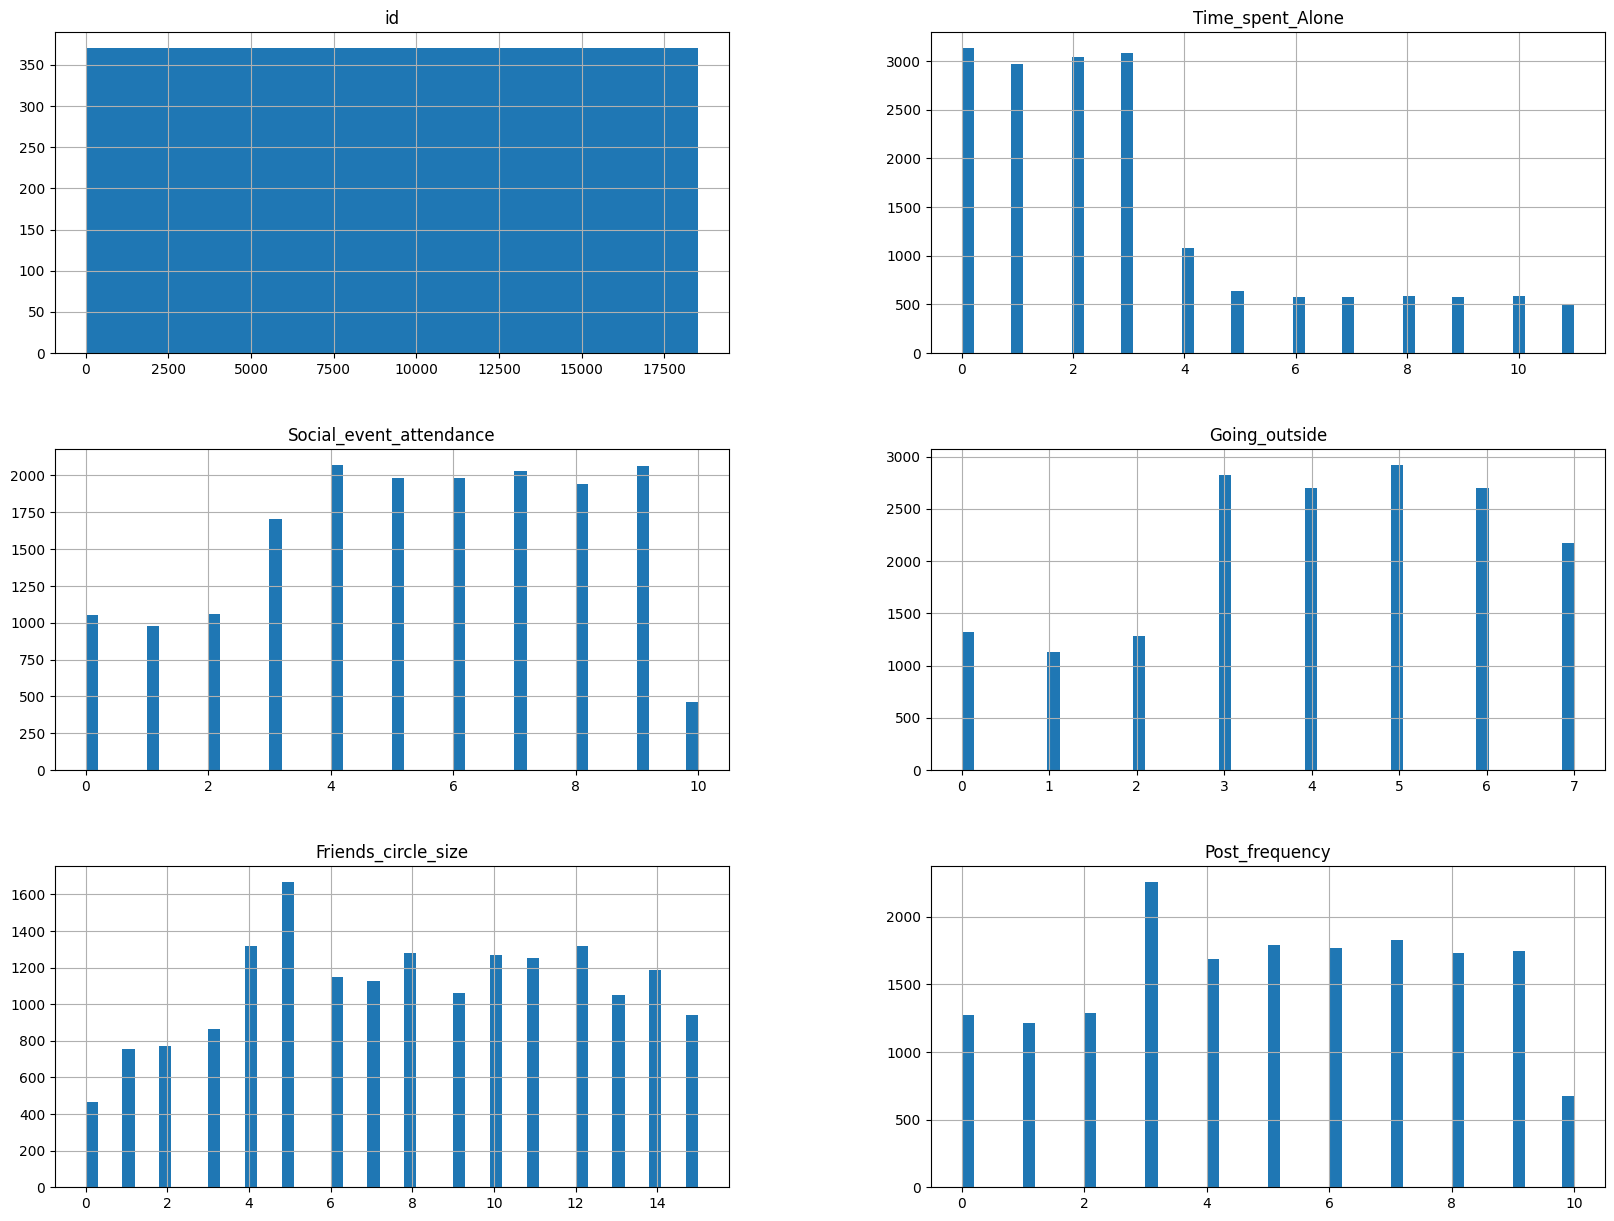


Valori nulli dopo imputazione:
Train: 0
Test: 0

Validation Accuracy: 0.9714
Validation AUC: 0.9575

Classification Report:
              precision    recall  f1-score   support

   Extrovert       0.98      0.98      0.98      2740
   Introvert       0.94      0.95      0.95       965

    accuracy                           0.97      3705
   macro avg       0.96      0.96      0.96      3705
weighted avg       0.97      0.97      0.97      3705



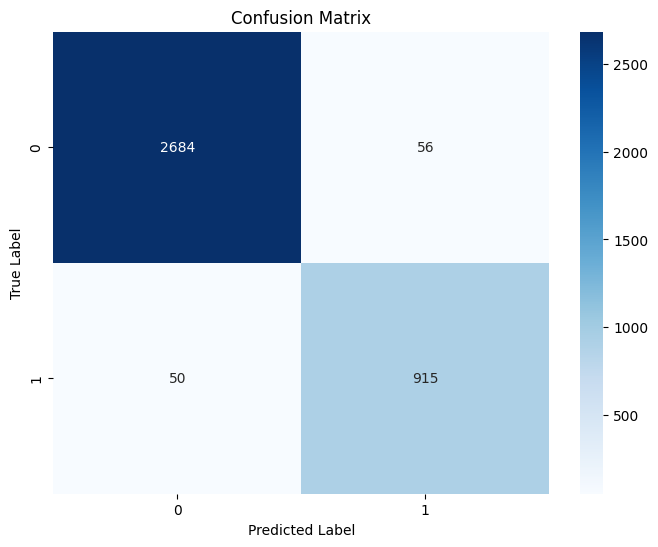

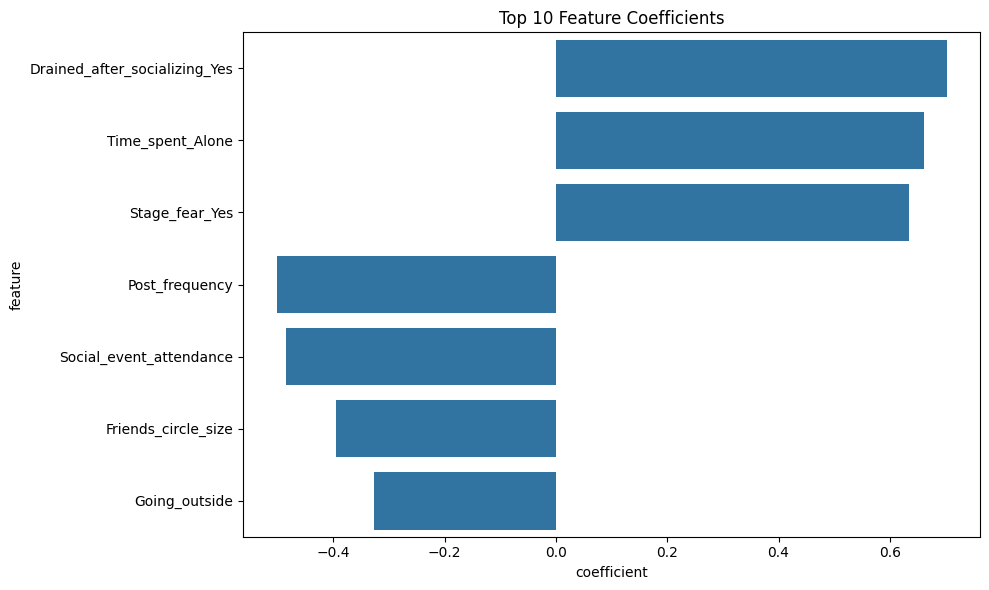


Top 10 Feature Importance:
                         feature  coefficient  abs_coefficient
6  Drained_after_socializing_Yes     0.701828         0.701828
0               Time_spent_Alone     0.662134         0.662134
5                 Stage_fear_Yes     0.633973         0.633973
4                 Post_frequency    -0.502009         0.502009
1        Social_event_attendance    -0.484604         0.484604
3            Friends_circle_size    -0.394594         0.394594
2                  Going_outside    -0.327180         0.327180

Predizioni salvate in submission.csv


TypeError: Cannot cast array data from dtype('O') to dtype('int64') according to the rule 'safe'

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# 1. CARICAMENTO DATI
df_train = pd.read_csv(r'C:\Users\pasti\Desktop\git_repo\project-data\projects\kaggle_competition\extroverts_predictions\train.csv')
df_test = pd.read_csv(r'C:\Users\pasti\Desktop\git_repo\project-data\projects\kaggle_competition\extroverts_predictions\test.csv')

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")

# 2. ANALISI VALORI NULLI
print("\nValori nulli train:")
print(df_train.isna().sum())
print("\nPercentuale valori nulli:")
print(df_train.isna().mean() * 100)

# 3. VISUALIZZAZIONE DISTRIBUZIONI
df_train.hist(bins=50, figsize=(20, 15))
plt.show()

# 4. PREPROCESSING - IMPUTAZIONE
# Definisci le colonne per tipo
mean_columns = ['Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']
cat_columns = ['Stage_fear', 'Drained_after_socializing']

# Imputazione per train set
imputer_median = SimpleImputer(strategy='median')
df_train['Time_spent_Alone'] = imputer_median.fit_transform(df_train[['Time_spent_Alone']])

imputer_mean = SimpleImputer(strategy='mean')
df_train[mean_columns] = imputer_mean.fit_transform(df_train[mean_columns])

imputer_mode = SimpleImputer(strategy='most_frequent')
df_train[cat_columns] = imputer_mode.fit_transform(df_train[cat_columns])

# Imputazione per test set (usando i fit del train)
df_test['Time_spent_Alone'] = imputer_median.transform(df_test[['Time_spent_Alone']])
df_test[mean_columns] = imputer_mean.transform(df_test[mean_columns])
df_test[cat_columns] = imputer_mode.transform(df_test[cat_columns])

print("\nValori nulli dopo imputazione:")
print("Train:", df_train.isna().sum().sum())
print("Test:", df_test.isna().sum().sum())

# 5. PREPARAZIONE FEATURES E TARGET
X_train = df_train.drop(columns=['Personality'])
y_train = df_train['Personality']
X_test = df_test.copy()

# 6. ENCODING VARIABILI CATEGORICHE
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
X_train_cat_encoded = enc.fit_transform(X_train[cat_columns])
X_test_cat_encoded = enc.transform(X_test[cat_columns])

# Crea nomi per le colonne encoded
cat_feature_names = enc.get_feature_names_out(cat_columns)

# 7. COMBINAZIONE FEATURES
# Variabili numeriche
num_columns = ['Time_spent_Alone'] + mean_columns
X_train_num = X_train[num_columns].values
X_test_num = X_test[num_columns].values

# Combina numeriche e categoriche
X_train_combined = np.hstack([X_train_num, X_train_cat_encoded])
X_test_combined = np.hstack([X_test_num, X_test_cat_encoded])

# Nomi delle features finali
feature_names = list(num_columns) + list(cat_feature_names)

# 8. SPLIT TRAIN/VALIDATION
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_combined, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# 9. SCALING
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_split)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test_combined)

# 10. TRAINING MODELLO
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train_split)

# 11. VALIDAZIONE
y_pred_val = model.predict(X_val_scaled)
y_pred_proba_val = model.predict_proba(X_val_scaled)[:, 1]

# Metriche
accuracy = accuracy_score(y_val, y_pred_val)
auc_score = roc_auc_score(y_val, y_pred_proba_val)

print(f"\nValidation Accuracy: {accuracy:.4f}")
print(f"Validation AUC: {auc_score:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_val))

# 12. CONFUSION MATRIX
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_pred_val)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 13. FEATURE IMPORTANCE
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': model.coef_[0]
})
feature_importance['abs_coefficient'] = abs(feature_importance['coefficient'])
feature_importance = feature_importance.sort_values('abs_coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(10), x='coefficient', y='feature')
plt.title('Top 10 Feature Coefficients')
plt.tight_layout()
plt.show()

print("\nTop 10 Feature Importance:")
print(feature_importance.head(10))

# 14. TRAINING FINALE SU TUTTO IL DATASET
X_train_full_scaled = scaler.fit_transform(X_train_combined)
model_final = LogisticRegression(max_iter=1000, random_state=42)
model_final.fit(X_train_full_scaled, y_train)

# 15. PREDIZIONI FINALI
y_test_pred = model_final.predict(X_test_scaled)
y_test_proba = model_final.predict_proba(X_test_scaled)[:, 1]

# 16. SUBMISSION
submission = pd.DataFrame({
    'id': range(len(df_test)),  # o df_test.index se c'è una colonna ID
    'prediction': y_test_pred
})
submission.to_csv('submission.csv', index=False)

print("\nPredizioni salvate in submission.csv")


In [2]:
submission = pd.DataFrame({
    'id': df_test["id"],  # o df_test.index se c'è una colonna ID
    'prediction': y_test_pred
})
submission.to_csv('submission.csv', index=False)